# Multi-Layer Perceptron for classifying an XOR dataset

## Generate an XOR dataset

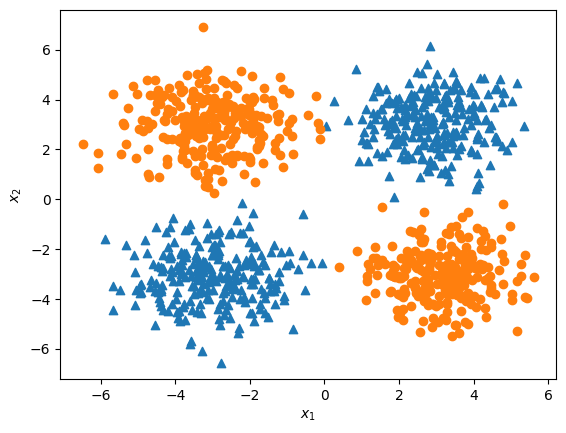

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

c = np.array([[-3, -3], [-3, 3], [3, -3], [3, 3]])
X, y = datasets.make_blobs(n_samples=1000,n_features=2,
                           centers=c, cluster_std=1.1,
                           random_state=123)

y = np.where(np.sign(X[:,0]) == np.sign(X[:,1]), 0, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], marker='^')
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

## Split data into: train, validation, test

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

In [3]:
print("Training size:", X_train.shape)
print("Validation size :", X_val.shape)
print("Test size: ", X_test.shape)

Training size: (765, 2)
Validation size : (85, 2)
Test size:  (150, 2)


In [4]:
import numpy as np

print("Training labels:", np.bincount(y_train))
print("Validation labels:", np.bincount(y_val))
print("Test labels:", np.bincount(y_test))

Training labels: [380 385]
Validation labels: [42 43]
Test labels: [74 76]


## Implement the model

In [5]:
import torch

class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
                
            # 1st hidden layer
            torch.nn.Linear(num_features, 30),
            torch.nn.Sigmoid(),

            # 2nd hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.Sigmoid(),

            # output layer
            torch.nn.Linear(20, num_classes),
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

## Dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]

train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
)

## Accuracy computation

In [7]:
def compute_accuracy(model, dataloader):

    model = model.eval()
    
    correct = 0.0
    total_examples = 0
    
    for idx, (features, labels) in enumerate(dataloader):
        
        with torch.inference_mode(): # same as torch.no_grad
            logits = model(features)
        
        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

## Training loop

In [12]:
import torch.nn.functional as F

torch.manual_seed(123)
model = MLP(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # Stochastic gradient descent

num_epochs = 200

for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)
        
        loss = F.cross_entropy(logits, labels) # Loss function
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        ## LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

Epoch: 001/200 | Batch 000/024 | Train/Val Loss: 0.70
Epoch: 001/200 | Batch 001/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 002/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 003/024 | Train/Val Loss: 0.73
Epoch: 001/200 | Batch 004/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 005/024 | Train/Val Loss: 0.70
Epoch: 001/200 | Batch 006/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 007/024 | Train/Val Loss: 0.67
Epoch: 001/200 | Batch 008/024 | Train/Val Loss: 0.75
Epoch: 001/200 | Batch 009/024 | Train/Val Loss: 0.70
Epoch: 001/200 | Batch 010/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 011/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 012/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 013/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 014/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 015/024 | Train/Val Loss: 0.70
Epoch: 001/200 | Batch 016/024 | Train/Val Loss: 0.69
Epoch: 001/200 | Batch 017/024 | Train/Val Loss: 0.70
Epoch: 001/200 | Batch 018/0

## Evaluating the accuracy

In [9]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 100.00%
Val Acc 100.00%
Test Acc 100.00%


## Decision boundary

In [10]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ['^', 'o', 'x', 's', 'v']
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    cmap = ListedColormap(colors[:len(np.unique(y))])
   
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker=markers[idx], 
                    label=cl)

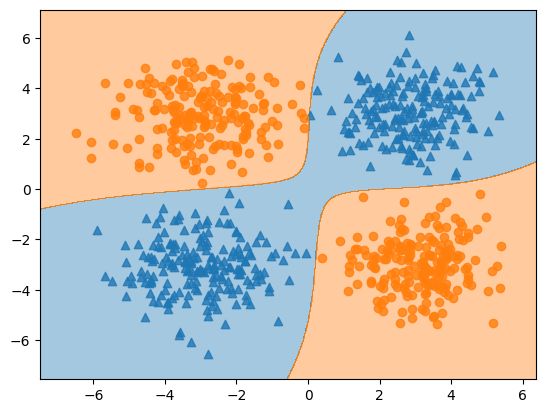

In [11]:
plot_decision_regions(X_train, y_train, classifier=model)